In [ ]:
!pip install gtfs-kit #install gtfs-kit which will be used to mine the gtfs (transit data)
import pandas as pd
import gtfs_kit as gk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 10.1 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sha256=d54451cefcfd0fa6bdae874c26b6f71b9e04a4e9695d6ea27e777b3802de0b07
  Stored in directory: /root/.cache/pip/wheels/91/96/d0/3cfff4cc9a9e307cfc2b8fe4846c56d714b78bbe5f6da211a5
Successfully built json2html


In [ ]:
#get google drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Final Project Files/Rail & Bus Combined GTFS Static.zip"#we can update this data since it is as of 27/Oct/2025
feed = gk.read_feed(path, dist_units = "km") #load gtfs from WMATA

stops.txt - provides the all the metro and bus stops data:
Important Fields:

- location_type: has values for the type of location that the bus stop is at. We are primarily interested in actual stops a metro station or a bus stop not sub stops within a stop so we will filter and use "0" for bis stops and "1" for stations.

In [ ]:
#the stops will likely be the nodes in the graph
stops_df = feed.stops
#bus stops are location_type = 0 or na
bus_stops = stops_df[(stops_df.location_type.isna()) | (stops_df.location_type == 0)]
#stations location_type =1
stations = stops_df[stops_df.location_type == 1]
print("Shape of stops dataframe:", bus_stops.shape)

Shape of stops dataframe: (7626, 14)


In [ ]:
bus_stops[(bus_stops.stop_name == "Huntington Av+Biscayne Dr")]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,level_id,platform_code
1417,14218,5002008,Huntington Av+Biscayne Dr,<NA>,38.794838,-77.07235,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


"In GTFS, a route defines a specific path or line on a map, while a trip is a single, specific instance of a vehicle traveling along that route at a particular time. A route groups together all its associated trips, which are variations of the same route that might have different schedules, directions (like inbound vs. outbound), or operate on different days of the week."

Important Fields:
route_type : Indicates the type of transportation used on a route.

In [ ]:
routes_df = feed.routes
print('Route Types:', routes_df.route_type.value_counts())
#route_type: 1 = metro, 3 = buses
routes_df[routes_df['route_type'] == 1]

Route Types: route_type
3    126
1      6
Name: count, dtype: Int64


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,as_route,route_text_color
14,BLUE,1,BL,Blue,<NA>,1,<NA>,0076C0,1,FFFFFF
85,GREEN,1,GR,Green,<NA>,1,<NA>,00A94F,1,FFFFFF
97,ORANGE,1,OR,Orange,<NA>,1,<NA>,F7941E,1,000000
128,RED,1,RD,Red,<NA>,1,<NA>,E31837,1,FFFFFF
130,SILVER,1,SV,Silver,<NA>,1,<NA>,A1A2A1,1,000000
131,YELLOW,1,YL,Yellow,<NA>,1,<NA>,FFD200,1,000000


In [ ]:
trips_df = feed.trips
stop_times_df = feed.stop_times
shapes_df = feed.shapes

In [ ]:
import datetime as dtt
#parse times

def parse_times(time):
    h, m, s = map(int, time.split(":"))
    days, h = divmod(h, 24)
    return pd.Timestamp("1900-01-01") + pd.to_timedelta(f"{days} days {h}:{m}:{s}") #adds days, hrs, mins, secs to date to allow for subtraction
    #using just time delta wouldn't work

#test parse times
print(parse_times("16:23:00"))
print(parse_times("24:25:00"))

1900-01-01 16:23:00
1900-01-02 00:25:00


In [ ]:
print(stops_df[stops_df['stop_id'] == '14218']['stop_lat'].values[0])

38.794838


In [ ]:
from sklearn.metrics.pairwise import haversine_distances
#calculate the distance travelled between two stops using haversine distance
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

def calculate_dist_travelled(stop, prev_stop):
    earth_r = 6371000 #in meters
    stop_lat = np.radians(stops_df[stops_df['stop_id'] == stop]['stop_lat'].values[0])
    stop_lon = np.radians(stops_df[stops_df['stop_id'] == stop]['stop_lon'].values[0])

    prev_stop_lat = np.radians(stops_df[stops_df['stop_id'] == prev_stop]['stop_lat'].values[0])
    prev_stop_lon = np.radians(stops_df[stops_df['stop_id'] == prev_stop]['stop_lon'].values[0])

    dist = haversine_distances([[stop_lat, stop_lon], [prev_stop_lat, prev_stop_lon]])[0, 1]#compute haversine distance and take the off diagonal which is the distance
    return round(dist * earth_r, 2) # multiply by Earth radius to get meters

#test
print(calculate_dist_travelled('21629', '14218'))

238.72


In [ ]:
#final versions of table before graphing
#there are several trips that go in the same direction. Overall there are two directions: 0 - Travel in one direction (e.g. outbound travel).
#1 - Travel in the opposite direction (e.g. inbound travel).
#we do not need every single trip that occurs every single day so we will aggregate and maybe apply some frequency attributes later on

#we need a unique id for each unique route
trips_grouped = trips_df.groupby(by = ['route_id', 'direction_id'])['trip_id'].agg(list) #group by route and directions to get all trips for that direction
# trips_grouped_test
trips_info = trips_grouped.reset_index() #reset index
trips_info = trips_info.explode('trip_id', ignore_index= True) #one row per trip

trips_info = trips_info.merge(stop_times_df, left_on = 'trip_id', right_on = 'trip_id').sort_values(by = ['trip_id', 'stop_sequence'] )
trips_info = trips_info.groupby(by = ['route_id', 'direction_id', 'trip_id'])['stop_id'].agg(list).reset_index()
trips_info['stop_id'] = trips_info['stop_id'].apply(tuple)
trips_info = trips_info.drop_duplicates(['route_id', 'direction_id', 'stop_id'])
trips_info['unique_id'] = trips_info['route_id'] + trips_info['direction_id'].astype(str) + trips_info['trip_id']

trips_final = trips_info.loc[:, ['unique_id', 'route_id', 'direction_id', 'trip_id']].copy()
#add stop_times
trips_final = trips_final.merge(stop_times_df, left_on = 'trip_id', right_on = 'trip_id')

#a little cleaning of the dates
trips_final['arrival_time'] = trips_final['arrival_time'].apply(parse_times)
trips_final['departure_time'] =  trips_final['departure_time'].apply(parse_times)
trips_final['prev_stop_id'] = trips_final.groupby(by = ['unique_id'])['stop_id'].shift(1, fill_value = 'first')
trips_final = trips_final.merge(routes_df[['route_id', 'route_type']], how = 'left', left_on = 'route_id', right_on='route_id')

#give routes a name for identification
routes_types = {1: 'Metro', 3: 'Bus'}
trips_final['route_type_name'] = trips_final['route_type'].map(routes_types)
trips_final

,unique_id,route_id,direction_id,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,prev_stop_id,route_type,route_type_name
0,A11010266070,A11,0,10266070,1900-01-01 14:26:00,1900-01-01 14:26:00,21629,2,<NA>,0,0,NaN,1,first,3,Bus
1,A11010266070,A11,0,10266070,1900-01-01 14:27:36,1900-01-01 14:27:36,14218,3,<NA>,0,0,NaN,0,21629,3,Bus
2,A11010266070,A11,0,10266070,1900-01-01 14:28:05,1900-01-01 14:28:05,11648,4,<NA>,0,0,NaN,0,14218,3,Bus
3,A11010266070,A11,0,10266070,1900-01-01 14:29:27,1900-01-01 14:29:27,11642,5,<NA>,0,0,NaN,0,11648,3,Bus
4,A11010266070,A11,0,10266070,1900-01-01 14:29:46,1900-01-01 14:29:46,14219,6,<NA>,0,0,NaN,0,11642,3,Bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17169,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:36:00,1900-01-01 06:36:00,PF_C11_2,6,<NA>,0,0,5.9456,<NA>,PF_C10_2,1,Metro
17170,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:39:00,1900-01-01 06:39:00,PF_C12_C,7,<NA>,0,0,7.4669,<NA>,PF_C11_2,1,Metro
17171,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:40:00,1900-01-01 06:40:00,PF_C13_C,8,<NA>,0,0,8.1578,<NA>,PF_C12_C,1,Metro
17172,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:42:00,1900-01-01 06:42:00,PF_C14_2,9,<NA>,0,0,8.8642,<NA>,PF_C13_C,1,Metro


In [ ]:
stops_df['location_type'] = stops_df['location_type'].fillna(0) #na values are also bus stops

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#attempting to create a small graph
G = nx.MultiDiGraph()#create empty graph

usable_stops_df = stops_df[(stops_df['location_type'] == 0)].reset_index().sort_values(by = 'stop_id')


nodes_info = []
#converting nodes data to dictionary for adding
for index, row in usable_stops_df.iterrows():
    #label location types
    if 'PF' in row['stop_id']:
        location_type = "Station"
    else:
        location_type = "Bus Stop"

    # print("adding node: ", index)#progress print
    node_id = row['stop_id']
    node_attributes = {"stop_name": row['stop_name'],
                       "stop_lat": row['stop_lat'],
                       "stop_lon": row['stop_lon'],
                       "stop_location_type": location_type,
                       "stop_wheelchair_accessible": row['wheelchair_boarding']}
    #add to nodes_info
    nodes_info.append((node_id, node_attributes))

print(f"Ensuring correct format: {nodes_info[:2]}")

#add nodes
G.add_nodes_from(nodes_info)

print(G)

Ensuring correct format: [('10000', {'stop_name': 'New Hampshire Av+Quebec St', 'stop_lat': 38.996655, 'stop_lon': -76.984741, 'stop_location_type': 'Bus Stop', 'stop_wheelchair_accessible': <NA>}), ('10001', {'stop_name': 'Riggs Rd+Ruatan St', 'stop_lat': 38.996704, 'stop_lon': -76.972763, 'stop_location_type': 'Bus Stop', 'stop_wheelchair_accessible': <NA>})]
MultiDiGraph with 7626 nodes and 0 edges


In [ ]:
#add edges, format: add_weighted_edges_from([(1, 2, 0.5), (3, 1, 0.75)]), (to, from, weight)
routes_list = trips_final['unique_id'].unique().tolist()
edges_info = []

for route in routes_list:
    temp_df =  trips_final[trips_final['unique_id'] == route].copy().sort_values(by = 'stop_sequence')
    prev_seq_num = temp_df.iloc[0]['stop_sequence'].item()
    print(f"{route} started")
    for index, row in temp_df.iterrows():
        # trip = row['trip_id']
        current_stop = row['stop_id']
        #handle first stops
        if row['prev_stop_id'] == "first":
            prev_stop = current_stop
        else:
            prev_stop = row['prev_stop_id']

        # print((prev_stop, current_stop))
        prev_dep_time = temp_df[(temp_df['stop_id'] == prev_stop) & (temp_df['stop_sequence'] == prev_seq_num)]['departure_time'].item()
        #calculate time between stops
        weight = (row['arrival_time'] - prev_dep_time).total_seconds()/60
        dist_trav = calculate_dist_travelled(current_stop, prev_stop)
        attributes = {"time": weight,
                      "distance": dist_trav,
                      "route": row['route_id'],
                      "direction": row['direction_id'],
                      'route_type': row['route_type_name']}
        info = (prev_stop, current_stop, attributes)

        if info in edges_info:
            print(info, row['trip_id'])
            prev_seq_num = row['stop_sequence']
            continue

        edges_info.append(info)
        prev_seq_num = row['stop_sequence']

    # edges_info
    print(f"{route} complete")

G.add_edges_from(edges_info)

A11010266070 started
A11010266070 complete
A1111003020 started
A1111003020 complete
A12010268020 started
A12010268020 complete
A12110140010 started
A12110140010 complete
A1X01000070 started
A1X01000070 complete
A1X110004070 started
A1X110004070 complete
A2501064020 started
A2501064020 complete
A25113353020 started
A25113353020 complete
A27010267020 started
A27010267020 complete
A27012272020 started
A27012272020 complete
A27012288020 started
('21713', '21713', {'time': 0.0, 'distance': np.float64(0.0), 'route': 'A27', 'direction': 0, 'route_type': 'Bus'}) 12288020
('16456', '27613', {'time': 7.0, 'distance': np.float64(3546.01), 'route': 'A27', 'direction': 0, 'route_type': 'Bus'}) 12288020
A27012288020 complete
A27022756020 started
('27842', '27842', {'time': 0.0, 'distance': np.float64(0.0), 'route': 'A27', 'direction': 0, 'route_type': 'Bus'}) 22756020
('1927', '1990', {'time': 0.5333333333333333, 'distance': np.float64(167.78), 'route': 'A27', 'direction': 0, 'route_type': 'Bus'}) 2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
#remove self loops
G.remove_edges_from(nx.selfloop_edges(G))
print(G)

MultiDiGraph with 7626 nodes and 15136 edges


In [ ]:
#visualize the graph
plt.figure(figsize = (20, 15))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 20)
nx.draw_networkx_edges(G, pos)
plt.show()

KeyboardInterrupt: 

<Figure size 2000x1500 with 0 Axes>

MultiDiGraph with 125 nodes and 298 edges


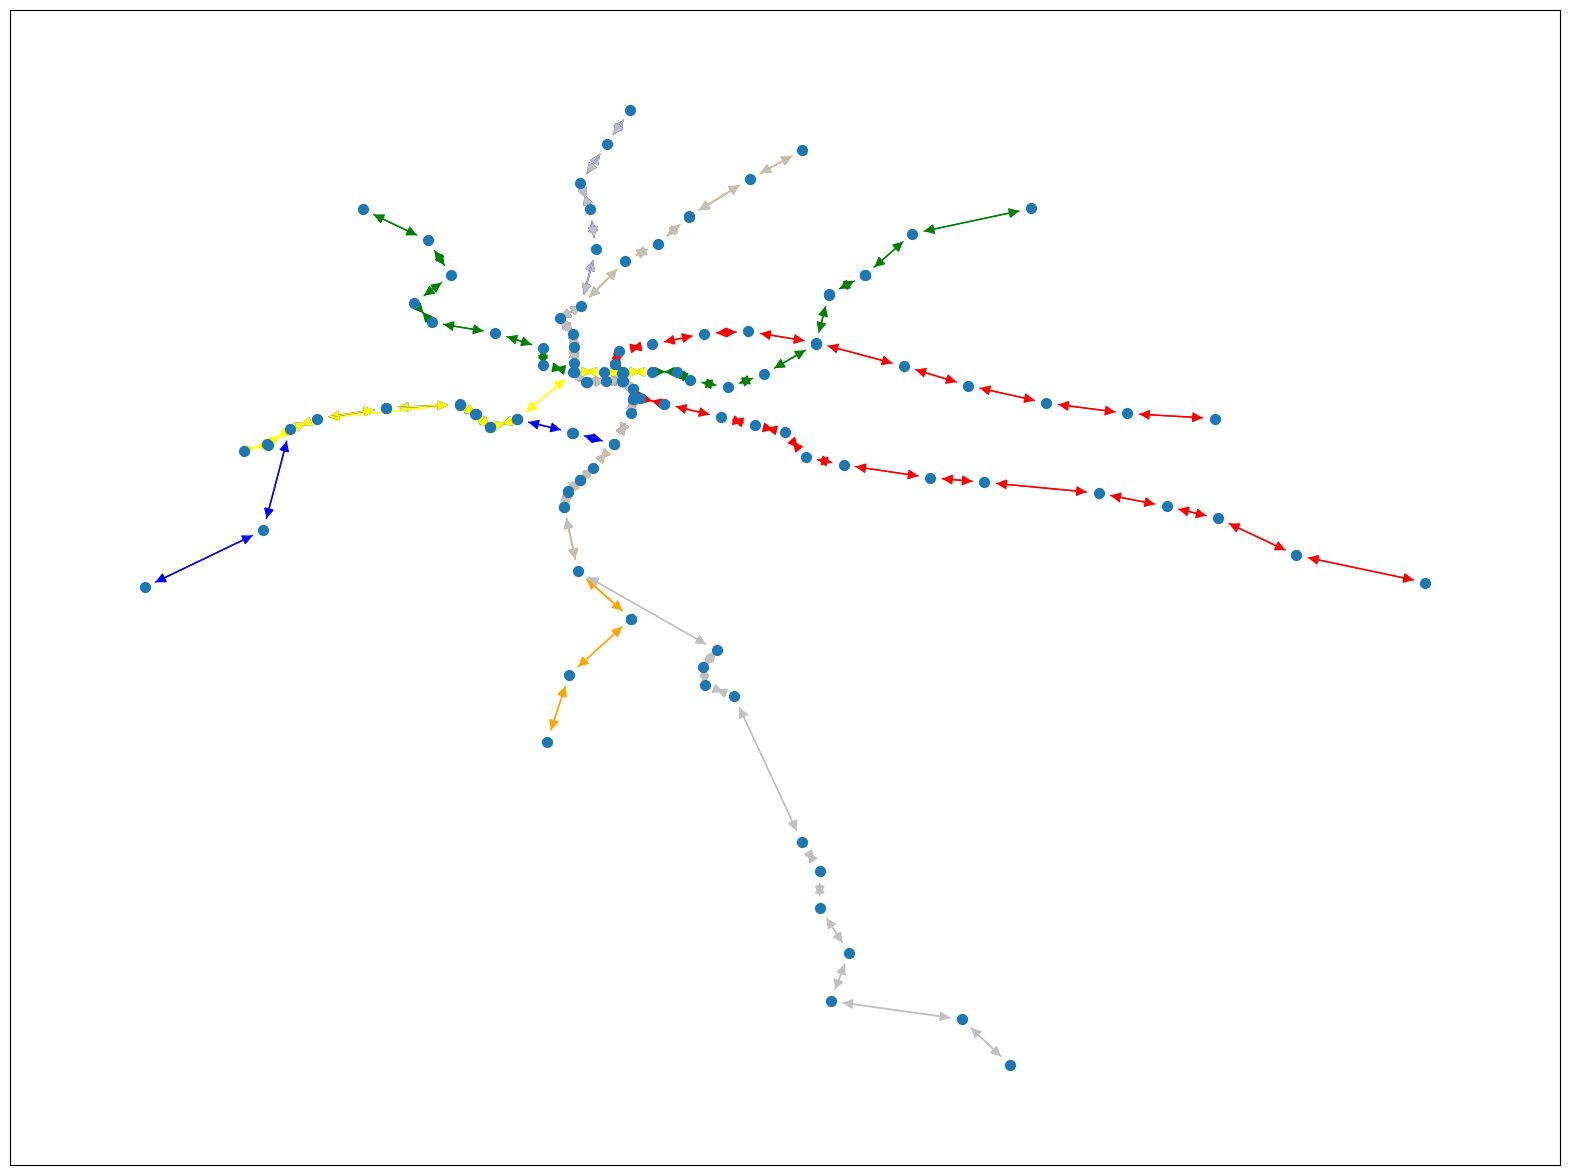

In [ ]:
#to visualize just the stations
station_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['route'] in ['GREEN', 'RED', 'YELLOW', 'ORANGE', 'BLUE', 'SILVER']]
station_nodes = [(u, d) for u, d in G.nodes(data=True) if  d['stop_location_type'] == 'Station']
G_stations = nx.MultiDiGraph()
G_stations.add_nodes_from(station_nodes)
G_stations.add_edges_from(station_edges)
# G_stations.remove_edges_from(nx.selfloop_edges(G_stations))
print(G_stations)

#visualize the graph
plt.figure(figsize = (20, 15))
edge_colors = [(d['route']) for u, v, d in G_stations.edges(data=True)]
pos_stat = {}
for u, d in G_stations.nodes(data = True):
    pos_stat[u] = [d['stop_lat'], d['stop_lon']]


nx.draw_networkx_nodes(G_stations, pos_stat, node_size = 50)
nx.draw_networkx_edges(G_stations, pos_stat, edge_color=edge_colors, arrowsize= 15)
plt.show()

Now we have the graph, the next thing is Transfers !

Thoughts:

if a stop is within walking distance 5 - 10 mins and if its on a different route then we can transfer

Reference: https://timvink.nl/blog/closest-coordinates/

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
#using open street map to check if a stop to stop is walkable - the distance could seem walkable, but there could no no real walkable path
places = [
    "Washington, District of Columbia, USA",
    "Arlington County, Virginia, USA",
    "Alexandria, Virginia, USA",
    "Fairfax County, Virginia, USA",
    "Montgomery County, Maryland, USA",
    "Prince George's County, Maryland, USA"
]

#combine all places in the DMV into a single graph
graphs = [ox.graph_from_place(p, network_type="walk") for p in places]
G_walk = nx.compose_all(graphs)
G_walk

In [ ]:
#pre-computing walkable edges prior to reduce computational time
osm_walkable = nx.all_pairs_dijkstra_path_length(G_walk, cutoff = 400, weight = 'length')
osm_walkable_edges = {}

for source, dist_dict in osm_walkable:
    for target, dist in dist_dict.items():
        osm_walkable_edges[(source, target)] = dist

# print(osm_walkable_edges)

In [ ]:
#pre-computing nearest nodes from G-walk for each stop
usable_stops_df = stops_df[(stops_df['location_type'] == 0)].reset_index().sort_values(by = 'stop_id')
stops_withGWalk = usable_stops_df.loc[:, ['stop_id', 'stop_lat', 'stop_lon']]
stops_withGWalk['gwalk_nearest'] = ox.distance.nearest_nodes(G_walk, stops_withGWalk['stop_lon'], stops_withGWalk['stop_lat'])
stop_gwalk_nodes = dict(zip(stops_withGWalk['stop_id'], stops_withGWalk['gwalk_nearest']))

In [ ]:
from scipy.spatial import KDTree
from sklearn.neighbors import BallTree
import numpy as np

stop_routes = trips_final.groupby(by = 'stop_id')['route_id'].agg(list).reset_index().sort_values(by = 'stop_id')

#convert to radians to accomodate distance metrics
stop_coords = np.radians(usable_stops_df[['stop_lat', 'stop_lon']]).values
#Ball tree creation using Haversine distance
stops_tree = BallTree(stop_coords, metric = 'haversine')

#a quarter mile or 400 meters is generally considered walkable
earth_r = 6371000  #earths radius
distance = 400 /earth_r #radius for 400 meters

walk_speed = 1.375 #average meters per second - https://en.wikipedia.org/wiki/Preferred_walking_speed
walk_max = 10 #maximum time to walk by transfer in mins

transfers_edges = []
#for each stop, check the closest stops within walking distance and create an edge
for k, stop in enumerate(stop_coords):
    print(f"Stop {k}")
    stop_2d = stop.reshape(1, -1) #rehshaping due to query_radius requirements - needs to be 2D
    nearest = stops_tree.query_radius(stop_2d, r = distance) #returns indices of neighbors within distance
    # print("1: ", nearest, k)
    for i in nearest[0]:
        # print("1.2: ", i, k)

        stop_route = stop_routes.iloc[k]['route_id']#routes that go through stops
        stop_id = stop_routes.iloc[k]['stop_id'] #id of the stop
        near_route = stop_routes.iloc[i]['route_id'] #routes that go through the nearest stop
        near_id = stop_routes.iloc[i]['stop_id']#id of nearest stop

        # print("1.3: ", stop_id, stop_route)
        # print("1.4: ", near_id, near_route)

        #skip nearest stops that are the same as the stop
        near = np.degrees(stop_coords[i])
        stop_deg = np.degrees(stop)

        if all(stop_deg == near):
            # print("skipped1")
            continue

        #checks and continues if any of the routes intersect - if they do then the person doesn't need to transfer at that point
        if any(route in stop_route for route in near_route):
            # print("skipped2")
            continue

        else:
            #get the nearest node from G_walk to determine if there is a walking path
            #Note since the graph is unprojected it automatically uses haversine, this was double checked using, G_walk.graph['crs']
            node1 = stop_gwalk_nodes[stop_id]
            node2 = stop_gwalk_nodes[near_id]
            # print("3: ",node1, node2)

            try:
                #get the walking distance between the stop and the nearest stop from the shortest path previously computed
                dist  = osm_walkable_edges[(node1, node2)]
                walk_time = (dist/walk_speed)/60 #minutes

            except KeyError:
                continue

            # print("4: ", walk_time, dist)

            if (walk_time <= walk_max):
                attributes = {"time": walk_time,
                              'distance': dist,
                              "route": 'transfer',
                              "direction": 2, #using 2 to prevent clash with normal directions
                              'route_type': 'transfer'}

                info = (stop_id, near_id, attributes)
                transfers_edges.append(info)#create edge details
G.add_edges_from(transfers_edges) #add transfer edges

Streaming output truncated to the last 5000 lines.
Stop 2626
Stop 2627
Stop 2628
Stop 2629
Stop 2630
Stop 2631
Stop 2632
Stop 2633
Stop 2634
Stop 2635
Stop 2636
Stop 2637
Stop 2638
Stop 2639
Stop 2640
Stop 2641
Stop 2642
Stop 2643
Stop 2644
Stop 2645
Stop 2646
Stop 2647
Stop 2648
Stop 2649
Stop 2650
Stop 2651
Stop 2652
Stop 2653
Stop 2654
Stop 2655
Stop 2656
Stop 2657
Stop 2658
Stop 2659
Stop 2660
Stop 2661
Stop 2662
Stop 2663
Stop 2664
Stop 2665
Stop 2666
Stop 2667
Stop 2668
Stop 2669
Stop 2670
Stop 2671
Stop 2672
Stop 2673
Stop 2674
Stop 2675
Stop 2676
Stop 2677
Stop 2678
Stop 2679
Stop 2680
Stop 2681
Stop 2682
Stop 2683
Stop 2684
Stop 2685
Stop 2686
Stop 2687
Stop 2688
Stop 2689
Stop 2690
Stop 2691
Stop 2692
Stop 2693
Stop 2694
Stop 2695
Stop 2696
Stop 2697
Stop 2698
Stop 2699
Stop 2700
Stop 2701
Stop 2702
Stop 2703
Stop 2704
Stop 2705
Stop 2706
Stop 2707
Stop 2708
Stop 2709
Stop 2710
Stop 2711
Stop 2712
Stop 2713
Stop 2714
Stop 2715
Stop 2716
Stop 2717
Stop 2718
Stop 2719
Stop 2720

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
from numpy._core.numeric import indices
#exporting the transit network so that we do not need to compute it every time (it is time consuming)
edges_df = pd.DataFrame(G.edges(data = True))
edges_df.to_csv("/content/drive/MyDrive/Final Project Files/wmata_edges.csv", index = False)

In [ ]:
#use this to load the edges back - then create the graph
edges_back = list(edges_df.itertuples(index = False, name = None))
edges_back

[('10000',
  '9918',
  {'time': 0.9166666666666666,
   'distance': np.float64(465.68),
   'route': 'M60',
   'direction': 1,
   'route_type': 'Bus'}),
 ('10001',
  '10045',
  {'time': 0.85,
   'distance': np.float64(200.94),
   'route': 'P15',
   'direction': 0,
   'route_type': 'Bus'}),
 ('10001',
  '10045',
  {'time': 0.8,
   'distance': np.float64(200.94),
   'route': 'P16',
   'direction': 0,
   'route_type': 'Bus'}),
 ('10002',
  '15256',
  {'time': 0.43333333333333335,
   'distance': np.float64(229.22),
   'route': 'P20',
   'direction': 1,
   'route_type': 'Bus'}),
 ('10002',
  '15256',
  {'time': 0.4166666666666667,
   'distance': np.float64(229.22),
   'route': 'P20',
   'direction': 1,
   'route_type': 'Bus'}),
 ('10003',
  '10038',
  {'time': 1.95,
   'distance': np.float64(399.21),
   'route': 'P20',
   'direction': 0,
   'route_type': 'Bus'}),
 ('10003',
  '10034',
  {'time': 1.1166666666666667,
   'distance': np.float64(633.22),
   'route': 'P20',
   'direction': 0,
   'r

The transit network is build. The next step is to find the average transit time from each neightborhood. Metrics we will get:
- number of walkable stops from each neighbourhood centroid
- num of schools/hospitals/clincs/pharmacies/grocery etc reachable within 30 mins
- mean travel time to key services eg. average time to nearest groceries
- average transfer count to key services
- average distance to key services
- num of connected subgraphs - disconnected areas = accessibility gaps

In [ ]:
def average_tran_time(centroid, wmata_network):
